<a id='home'></a>
### purpose

create PCAs for climate that display the populations as well as the common gardens


### outline
1. [read in common garden climate data](#cgdata)
    - get average climate of each common garden for the years in which individuals were grown
1. [get environmental data](#envdata)
    - get current environmental data for each clade, assign shapes and colors
1. [center and scale environmental data](#scale)
1. [PCAs for each clade (+ combined interior+coastal Douglas-fir)](#clade)
1. [PCAs across all species/clades](#all)

In [1]:
from pythonimports import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

t1 = dt.now()  # notebook timer

latest_commit()
session_info.show()

##################################################################
Current commit of pythonimports:
commit 29355f0d2523f0764a8ef91a717e16299fc5c02d  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jul 15 13:22:04 2022 -0400
Today:	August 01, 2022 - 11:38:23
python version: 3.8.5
##################################################################



<a id='cgdata'></a>
# 1. Read in common garden climate data

[top](#home)

### doug-fir

In [2]:
# doug-fir vancouver data
vanfile = '/data/projects/pool_seq/environemental_data/vancouver_data/vancouver_climate-2018-2019_USING.txt'
vanclim = pd.read_table(vanfile, index_col=0)
vanclim = vanclim[vanclim.index =='two_year_avg']
vanclim.index = ['vancouver']
vanclim.columns.values[:2] = ['Latitude', 'Longitude']
vanclim

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
vancouver,49.257,-123.25,81.0,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0


### jack pine

In [3]:
# jack pine
jpdir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
jpclim = pd.read_table(
    op.join(jpdir,
            'jack_pine_common_gardens_average_climate_1966-2018.txt'),
    index_col=0
).loc[['christine', 'fontbrune']]

jpclim

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,156,12.179245,77.132075,1739.150943,1281.716981,-38.9,43.6,621.962264,127.056604,1162.169811,3.998113,-13.845283,561.150943,18.962264,157.113208,358.075472,34.554717,32.811321,141.094340,268.169811
fontbrune,46.959018,-75.698440,247,13.962264,135.018868,1624.962264,1418.849057,-41.1,42.6,646.849057,116.056604,953.754717,3.237736,-15.224528,475.490566,18.154717,144.320755,298.849057,38.800000,33.377358,147.358491,263.471698


### combine

In [4]:
# combine
cgdata = pd.concat([jpclim, vanclim])
cgdata.head()

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,156.0,12.179245,77.132075,1739.150943,1281.716981,-38.9,43.6,621.962264,127.056604,1162.169811,3.998113,-13.845283,561.150943,18.962264,157.113208,358.075472,34.554717,32.811321,141.094340,268.169811
fontbrune,46.959018,-75.698440,247.0,13.962264,135.018868,1624.962264,1418.849057,-41.1,42.6,646.849057,116.056604,953.754717,3.237736,-15.224528,475.490566,18.154717,144.320755,298.849057,38.800000,33.377358,147.358491,263.471698
vancouver,49.257000,-123.250000,81.0,18.050000,301.000000,2487.500000,86.500000,-13.5,35.0,648.000000,262.000000,1194.000000,11.200000,5.400000,259.000000,19.650000,320.500000,36.000000,76.650000,14.250000,60.000000,322.000000


In [5]:
# isolate envs

envs = cgdata.columns[-20:]
assert len(envs) == 20  # 19 clim + elevation

envs

Index(['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP',
       'MAP', 'MAT', 'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP',
       'eFFP'],
      dtype='object')

<a id='envdata'></a>
# 2. get environmental data

[top](#home)

##### read in env data

In [6]:
colors = {'fdc' : 'lime', 'fdi' : 'purple', 'jp' : 'green', 'combined' : 'red'}
garden_colors = {'christine' : 'yellow', 'fontbrune': 'red', 'vancouver' : 'dodgerblue'}

spp_marker = {'fdc' : 'v', 'fdi' : 'o', 'jp' : 's'}

# read in pops and group names
envdfs = {}

# coastal douglas-fir
envdfs['fdc'] = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt')

# interior douglas-fir
fdi = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt')
fdi.loc[fdi['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'
envdfs['fdi'] = fdi.copy()

# both varieties of douglas-fir
comb = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
envdfs['combined'] = comb.copy()

# jack pine
envdfs['jp'] = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt')
envdfs['jp']['group'] = envdfs['jp']['group_color']

# add pop name as index
for spp, df in envdfs.items():
    df.index = df['our_id'].tolist()

# add color to combined
for col in ['group', 'group_color']:
    envdfs['combined'].loc[envdfs['fdi'].index, col] = envdfs['fdi'][col]
    envdfs['combined'].loc[envdfs['fdc'].index, col] = envdfs['fdc'][col]
    
# add common garden info, reduce to envs and group_color
for spp, df in envdfs.items():
    df = df[list(envs) + ['group', 'group_color']].copy()
    gardens = ['vancouver'] if spp != 'jp' else ['christine', 'fontbrune']
    for garden in gardens:
        df.loc[garden, envs] = cgdata.loc[garden, envs]
        df.loc[garden, 'group_color'] = garden_colors[garden]
        
    envdfs[spp] = df.copy()
    
# which marker to use in plots?
pop_marker = defaultdict(dict)
for spp, df in envdfs.items():
    for pop in df.index:
        if spp != 'combined':
            pop_marker[spp][pop] = spp_marker[spp]
        else:
            if pop in envdfs['fdi'].index.tolist():
                pop_marker[spp][pop] = spp_marker['fdi']
            else:
                assert pop in envdfs['fdc'].index.tolist()
                pop_marker[spp][pop] = spp_marker['fdc']
        if pop in ['vancouver', 'christine', 'fontbrune']:
            pop_marker[spp][pop] = 'D'

for spp, envdf in envdfs.items():
    print(ColorText(spp).custom(colors[spp]).bold())
    display(envdf.head())

fdc


,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group,group_color
DF_p1,225.0,4.6,10.0,1644.0,143.0,-18.3,33.3,606.0,186.0,4004.0,8.4,2.3,778.0,15.6,277.0,242.0,20.0,13.3,115.0,301.0,Western BC,#a6cee3
DF_p2,550.0,15.6,307.0,1521.0,518.0,-30.9,35.2,659.0,137.0,1029.0,6.1,-4.4,225.0,16.4,202.0,330.0,73.0,20.8,135.0,272.0,Lower Mainland,#33a02c
DF_p6,460.0,18.2,392.0,1440.0,741.0,-38.4,35.0,667.0,108.0,827.0,5.1,-7.3,180.0,15.8,172.0,351.0,87.8,23.2,149.0,257.0,Western BC,#a6cee3
DF_p10,152.0,12.2,192.0,1727.0,182.0,-20.5,34.8,651.0,178.0,1502.0,8.3,0.9,301.0,16.6,265.0,128.0,55.0,15.7,116.0,294.0,Western BC,#a6cee3
DF_p11,732.0,7.2,149.0,1203.0,336.0,-24.1,32.5,529.0,153.0,2204.0,5.8,-1.1,301.0,14.4,225.0,547.0,47.9,15.5,133.0,286.0,Western BC,#a6cee3


fdi


,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group,group_color
DF_p3,1525.0,18.5,151.0,929.0,1242.0,-43.3,32.6,548.0,73.0,630.0,1.6,-10.7,321.0,13.4,130.0,261.0,41.8,24.1,171.0,244.0,Eastern BC,#22ff00
DF_p4,900.0,32.9,350.0,1270.0,919.0,-40.2,34.9,598.0,101.0,423.0,3.9,-9.2,196.0,15.3,158.0,149.0,78.2,24.5,154.0,255.0,North BC,#f205f4
DF_p5,853.0,43.8,497.0,1650.0,637.0,-34.8,37.7,732.0,123.0,367.0,6.0,-6.2,171.0,17.7,182.0,100.0,103.6,23.9,142.0,265.0,Tri-state,#995bbe
DF_p7,684.0,15.2,174.0,1239.0,1031.0,-40.5,33.6,552.0,106.0,880.0,3.4,-10.3,341.0,15.0,162.0,372.0,43.9,25.3,150.0,256.0,North BC,#f205f4
DF_p8,850.0,21.1,240.0,991.0,1210.0,-42.3,32.4,521.0,86.0,572.0,2.1,-11.3,235.0,13.7,143.0,262.0,58.4,25.0,164.0,250.0,North BC,#f205f4


combined


,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group,group_color
DF_p1,225.0,4.6,10.0,1644.0,143.0,-18.3,33.3,606.0,186.0,4004.0,8.4,2.3,778.0,15.6,277.0,242.0,20.0,13.3,115.0,301.0,Western BC,#a6cee3
DF_p2,550.0,15.6,307.0,1521.0,518.0,-30.9,35.2,659.0,137.0,1029.0,6.1,-4.4,225.0,16.4,202.0,330.0,73.0,20.8,135.0,272.0,Lower Mainland,#33a02c
DF_p3,1525.0,18.5,151.0,929.0,1242.0,-43.3,32.6,548.0,73.0,630.0,1.6,-10.7,321.0,13.4,130.0,261.0,41.8,24.1,171.0,244.0,Eastern BC,#22ff00
DF_p4,900.0,32.9,350.0,1270.0,919.0,-40.2,34.9,598.0,101.0,423.0,3.9,-9.2,196.0,15.3,158.0,149.0,78.2,24.5,154.0,255.0,North BC,#f205f4
DF_p5,853.0,43.8,497.0,1650.0,637.0,-34.8,37.7,732.0,123.0,367.0,6.0,-6.2,171.0,17.7,182.0,100.0,103.6,23.9,142.0,265.0,Tri-state,#995bbe


jp


,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group,group_color
JP_p98,537.0,21.2,181.0,1273.0,2217.0,-46.0,34.7,534.0,103.0,461.0,-0.2,-20.1,305.0,16.6,149.0,129.0,54.4,36.7,148.0,251.0,green,green
JP_p73,359.0,22.0,241.0,1956.0,835.0,-34.1,36.6,745.0,131.0,732.0,6.1,-8.0,395.0,19.8,163.0,140.0,50.0,27.8,141.0,271.0,blue,blue
JP_p97,636.0,23.5,242.0,1188.0,2009.0,-44.3,34.8,556.0,90.0,432.0,0.2,-19.8,272.0,15.4,138.0,133.0,56.5,35.1,151.0,241.0,green,green
JP_p60,203.0,16.5,135.0,1557.0,1116.0,-36.8,34.3,599.0,123.0,848.0,4.0,-10.7,397.0,17.6,156.0,265.0,44.2,28.3,147.0,271.0,blue,blue
JP_p100,205.0,13.3,130.0,1003.0,2956.0,-49.7,35.2,448.0,82.0,506.0,-3.3,-24.9,315.0,15.7,106.0,191.0,49.9,40.6,163.0,245.0,green,green


<a id='scale'></a>
# 3. center and scale envdata

[top](#home)

In [7]:
for spp, df in envdfs.items():
    # center and scale
    envdata = pd.DataFrame(StandardScaler().fit_transform(df[envs]),
                           index=df.index,
                           columns=envs)
    # add back group info
    envdata['group'] = df['group']
    envdata['group_color'] = df['group_color']
    
    envdfs[spp] = envdata.copy()
    
    # make sure it did what I think it would do
    for env in envs:
        _mean = round(envdfs[spp][env].mean(), 1)
        _std = round(envdfs[spp][env].std(), 1)
        assert _mean == 0, _mean
        assert _std == 1, _std
        

<a id='clade'></a>
# 4. Clade PCAs

[top](#home)

### do PCAs without elevation

In [8]:
def get_pca_scores(data, n_components=None):
    """Run principal component analysis."""
    pca = PCA(n_components=n_components)
    pca.fit(data)
    scores_pca = pca.transform(data)
    scores_df = pd.DataFrame(scores_pca, index=data.index)

    return scores_pca, scores_df, pca

def plot_pcas(envdfs, use_elevation=False, n_components=3):    
    _envs = envs if use_elevation is True else envs[1:]
    extra_title = 'with elevation' if use_elevation is True else 'without elevation'
    
    for spp, df in envdfs.items():
        print(ColorText(spp).custom(colors[spp]).bold())

        data = df[_envs].copy()

        scores_pca, scores_df, pca = get_pca_scores(data, n_components=n_components)

        for i, pc_i in enumerate(scores_df.columns):
            i_var_explained = round(pca.explained_variance_ratio_[i] * 100, 2)

            for j, pc_j in enumerate(scores_df.columns):
                j_var_explained = round(pca.explained_variance_ratio_[j] * 100, 2)

                if i < j:  # unique comparisons
                    
                    for pop, color in df['group_color'].items():
                        score_i, score_j = scores_df.loc[pop, [pc_i, pc_j]]
                        plt.scatter(score_i, score_j, c=color, marker=pop_marker[spp][pop])
                        
                    plt.xlabel(f'PC-{i + 1} ({i_var_explained}%)')
                    plt.ylabel(f'PC-{j + 1} ({j_var_explained}%)')
                    plt.title(f'{spp} {extra_title}\nPC-{i + 1} vs PC-{j + 1}')
                    
                    fig = plt.gcf()
                    fig.set_size_inches(8, 8)
                    
                    plt.show()

    pass

fdc


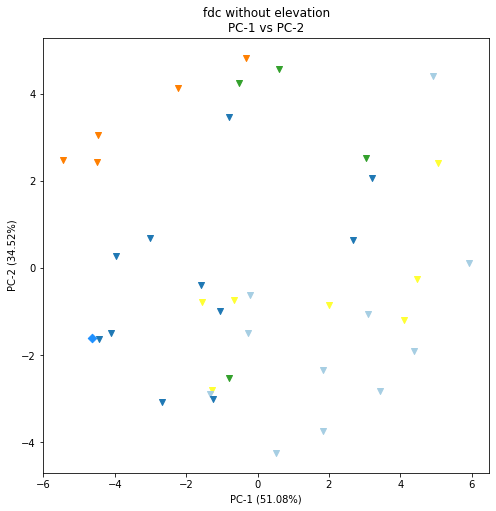

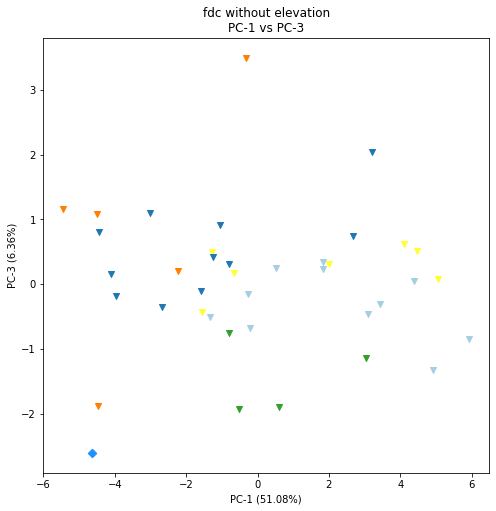

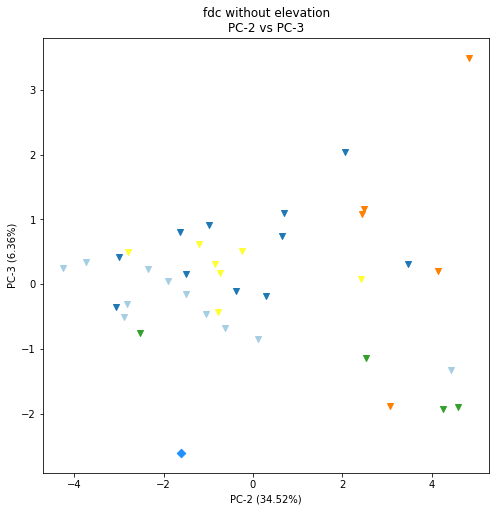

fdi


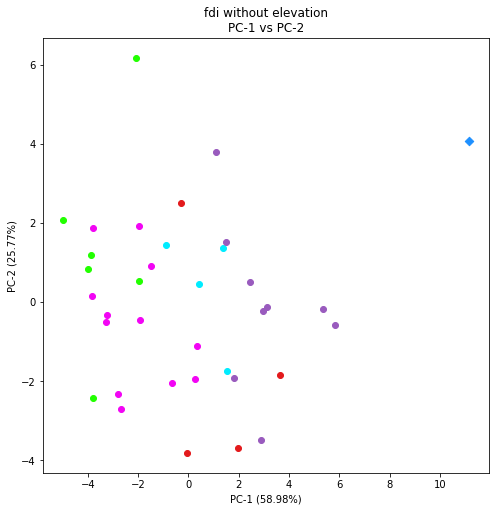

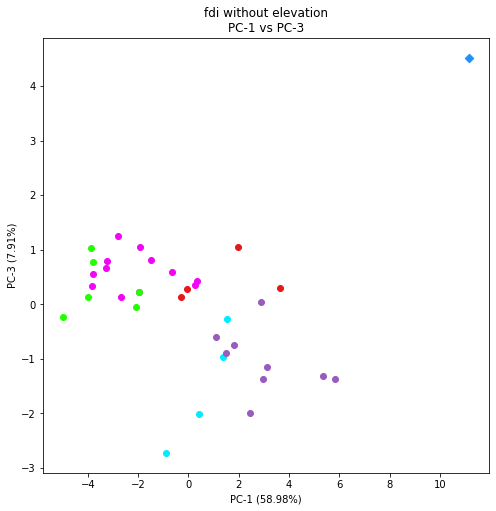

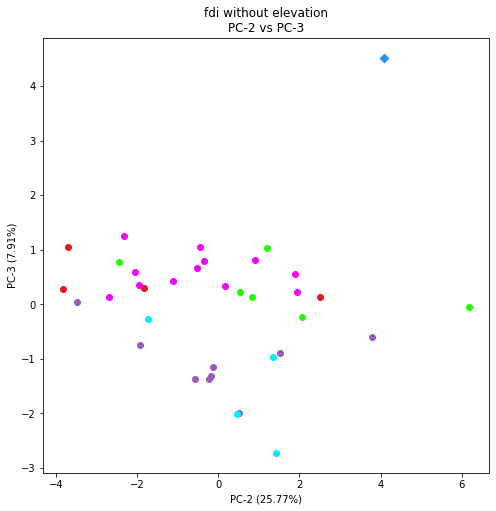

combined


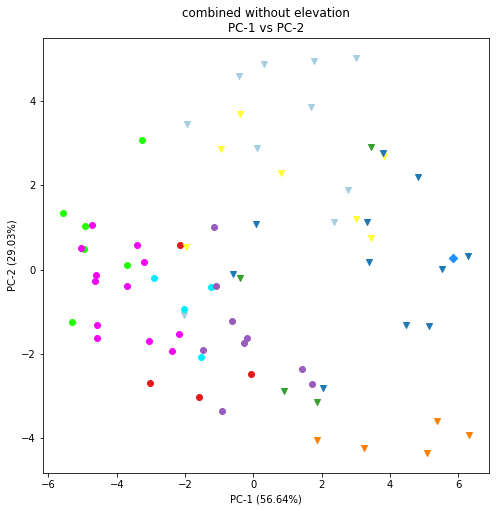

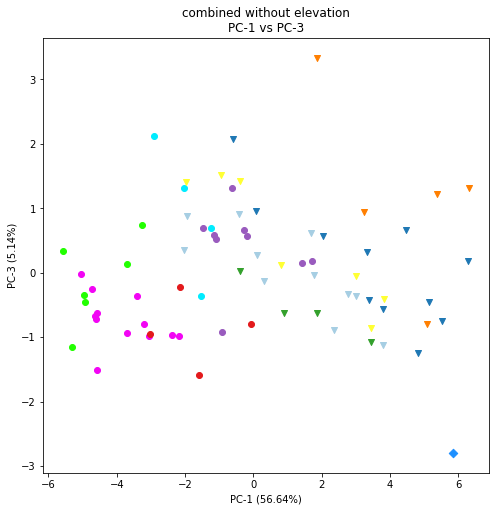

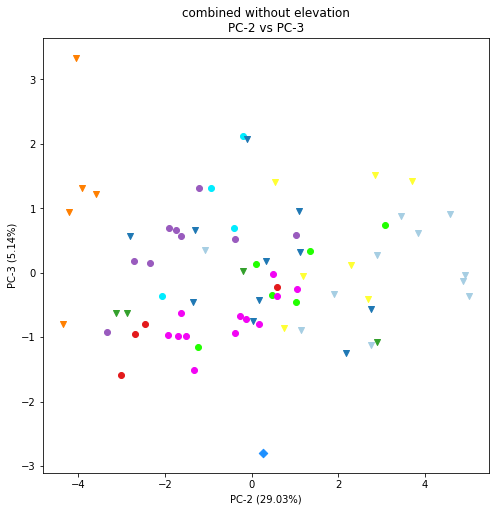

jp


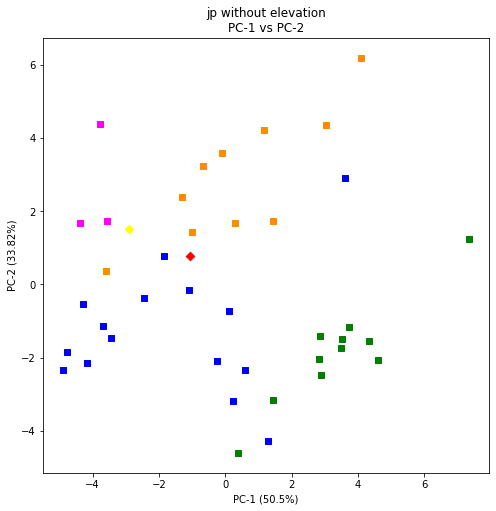

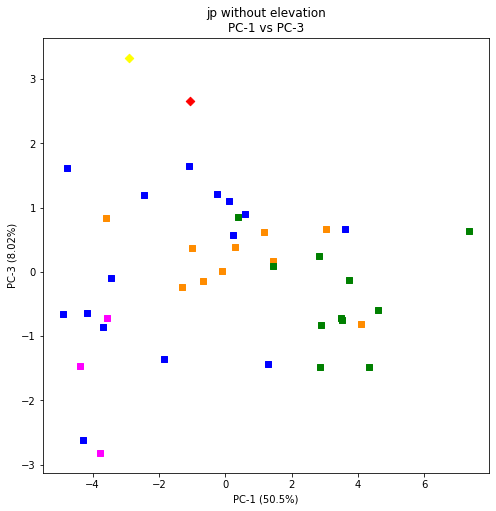

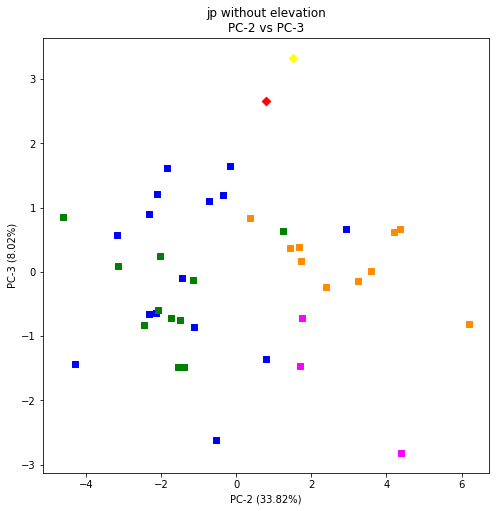

In [9]:
plot_pcas(envdfs)

### do PCAs with elevation

fdc


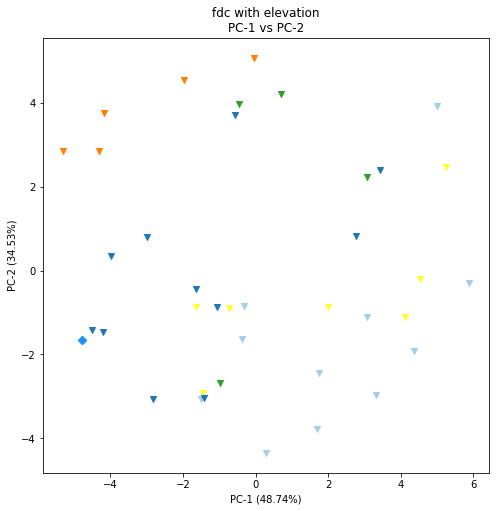

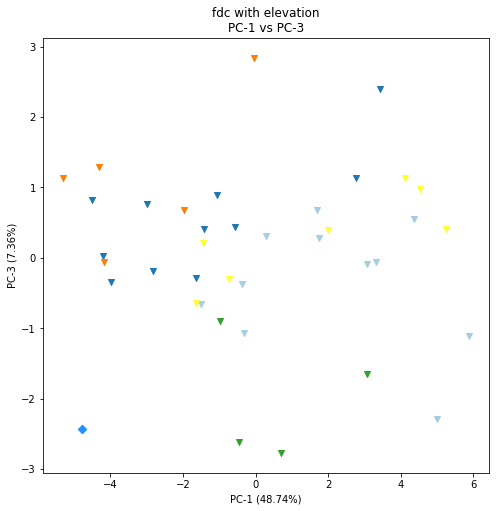

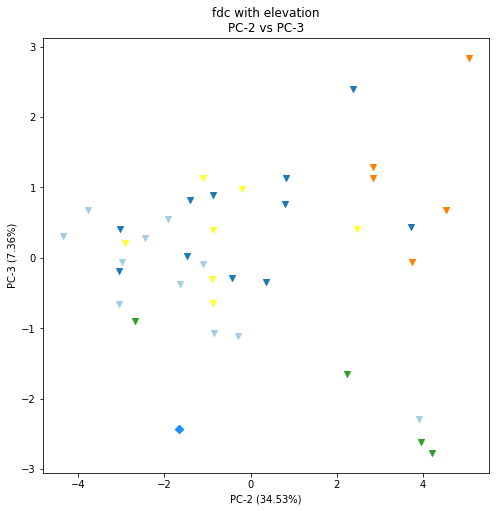

fdi


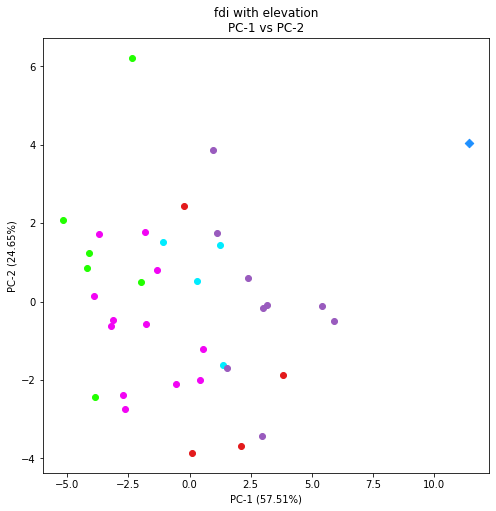

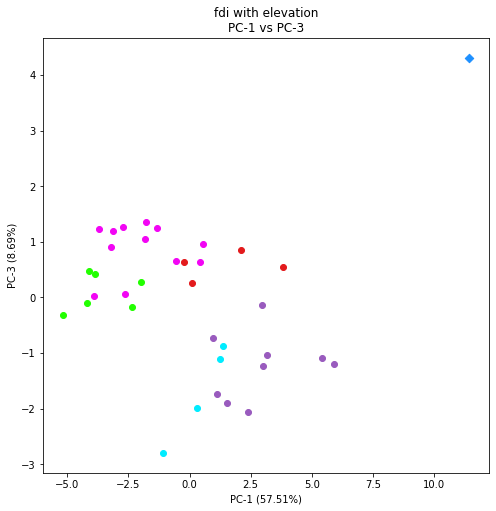

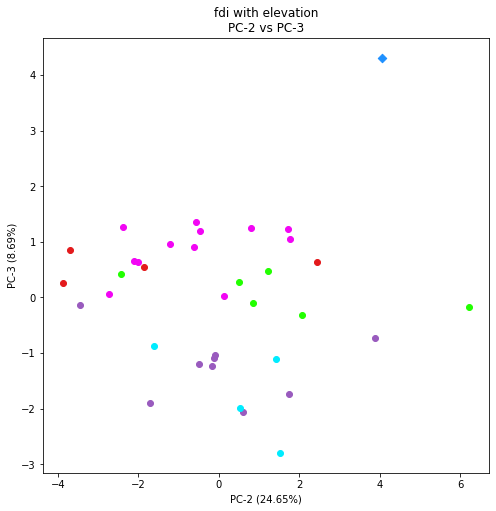

combined


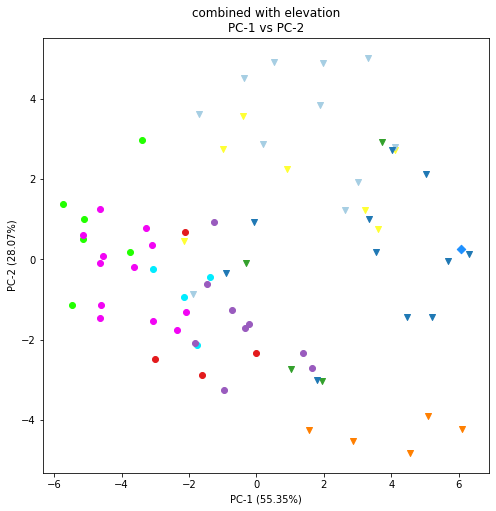

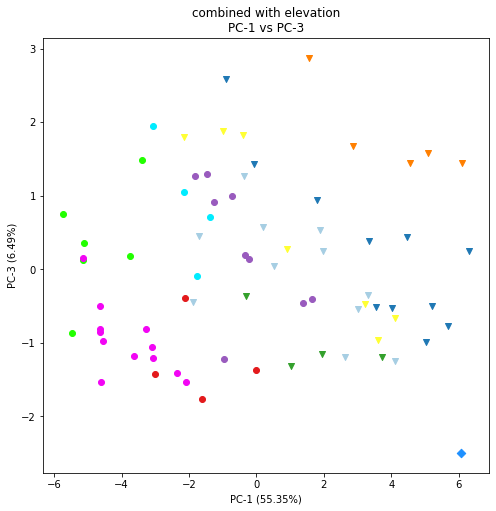

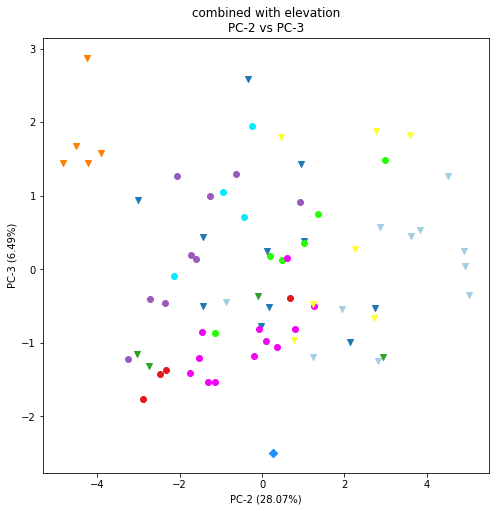

jp


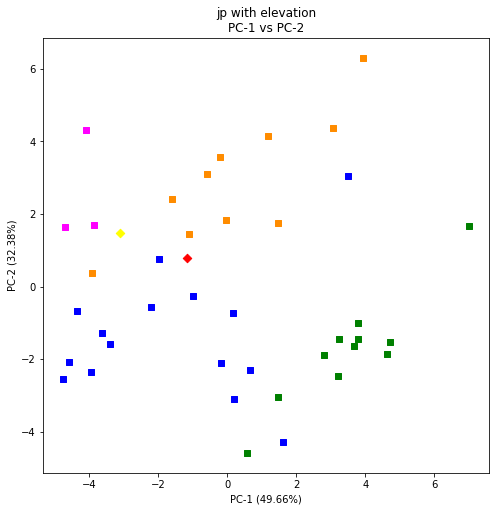

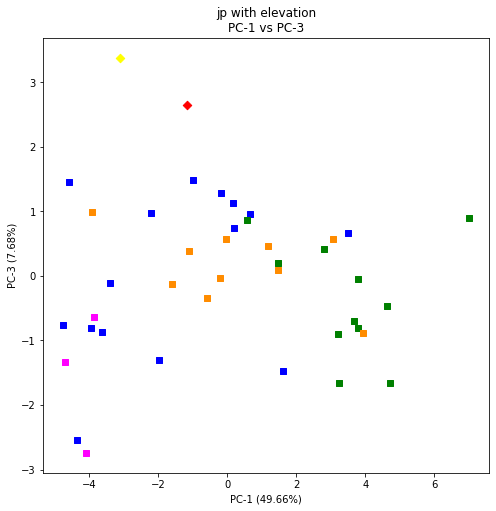

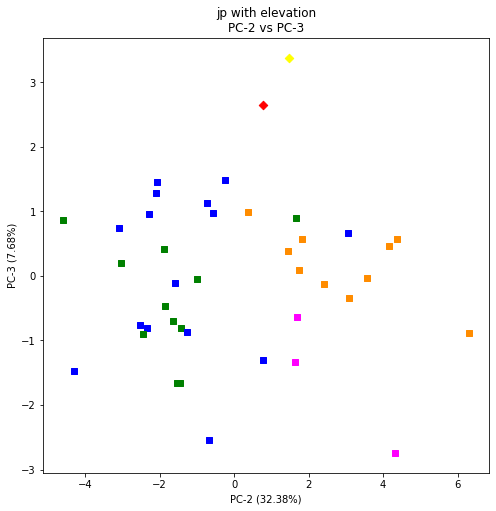

In [10]:
plot_pcas(envdfs, use_elevation=True)

<a id='all'></a>
# 5. all species

[top](#home)

In [11]:
colors['all'] = 'blue'

all_data = {}
df = pd.concat([envdfs['combined'], envdfs['jp']], axis=0)

df['marker'] = np.nan
df['marker'].loc[envdfs['fdc'].index] = df.loc[envdfs['fdc'].index].index.map(pop_marker['fdc'])
df['marker'].loc[envdfs['fdi'].index] = df.loc[envdfs['fdi'].index].index.map(pop_marker['fdi'])
df['marker'].loc[envdfs['jp'].index] = df.loc[envdfs['jp'].index].index.map(pop_marker['jp'])

pop_marker['all'] = dict(zip(df.index, df['marker']))

# center and scale
envdata = pd.DataFrame(StandardScaler().fit_transform(df[envs]),
                       index=df.index,
                       columns=envs)

# add back group info
envdata['group'] = df['group']
envdata['group_color'] = df['group_color']

all_data['all'] = envdata.copy()

all_data['all']

/lu213/brandon.lind/data/anaconda3/envs/newpy385/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group,group_color
DF_p1,-1.350983,-1.279186,-1.734752,0.145350,-0.970993,1.227842,-0.777725,-0.562264,1.081456,2.920140,0.674801,1.077215,3.554738,-0.321014,1.205919,-0.056254,-0.964839,-1.470019,-1.068798,1.035980,Western BC,#a6cee3
DF_p2,-0.618359,-0.197192,0.109329,-0.107006,-0.018652,-0.137501,-0.034366,-0.219096,0.010631,-0.355141,-0.099129,-0.215652,-0.468689,0.035869,-0.108854,0.405112,-0.017879,0.277193,-0.212834,-0.192994,Lower Mainland,#33a02c
DF_p3,1.579513,0.088062,-0.859279,-1.321600,1.820001,-1.481172,-1.051594,-0.937806,-1.387996,-0.794414,-1.613339,-1.431332,0.229772,-1.302441,-1.371036,0.043359,-0.575335,1.045966,1.327901,-1.379589,Eastern BC,#22ff00
DF_p4,0.170621,1.504491,0.376317,-0.621978,0.999718,-1.145254,-0.151738,-0.614063,-0.776097,-1.022307,-0.839409,-1.141885,-0.679682,-0.454844,-0.880187,-0.543834,0.075030,1.139151,0.600331,-0.913427,North BC,#f205f4
DF_p5,0.064672,2.576650,1.289045,0.157660,0.283557,-0.560107,0.943738,0.253570,-0.295318,-1.083959,-0.132778,-0.562989,-0.861573,0.615803,-0.459460,-0.800731,0.528856,0.999374,0.086753,-0.489642,Tri-state,#995bbe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JP_p4,-1.437107,-1.316889,-1.708957,-0.345400,-1.698490,2.458496,-1.828765,-1.057002,0.765291,2.274582,1.092819,2.114964,1.027493,-0.711563,0.469689,1.285610,-1.238380,-2.642358,0.165901,1.342981,magenta,magenta
JP_p101,1.541456,1.208563,1.012851,-0.659851,0.927030,-0.927549,-0.300307,-0.510213,-0.568742,-1.282359,-0.914072,-0.887427,-1.311974,-0.645434,0.211692,-1.046037,1.148456,0.771356,-0.431452,-1.229192,green,green
JP_p102,0.417725,0.299400,0.339562,-0.902835,1.367943,-1.139177,-0.257850,-0.926814,-0.919803,-1.065849,-1.290365,-1.278149,-1.027277,-0.645434,-0.046304,-0.754581,0.715446,1.209603,0.613916,-1.005524,green,green
christine,-1.159559,-1.098842,-0.933499,0.719983,-0.563153,0.490357,3.308553,0.374573,0.769265,1.517456,0.632118,0.275428,1.982478,0.652190,0.541490,1.100805,-1.274846,-0.079461,-0.716040,0.690970,NaN,yellow


### with elevation

all


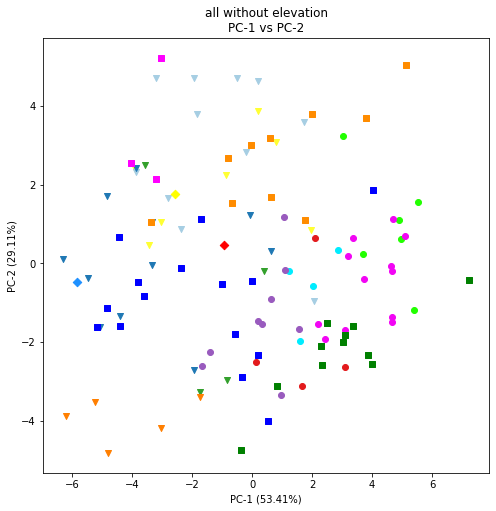

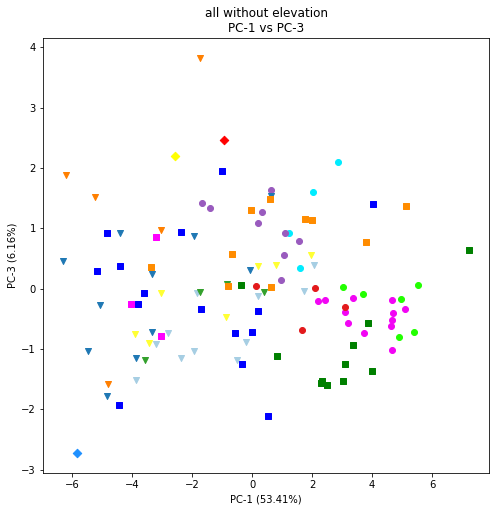

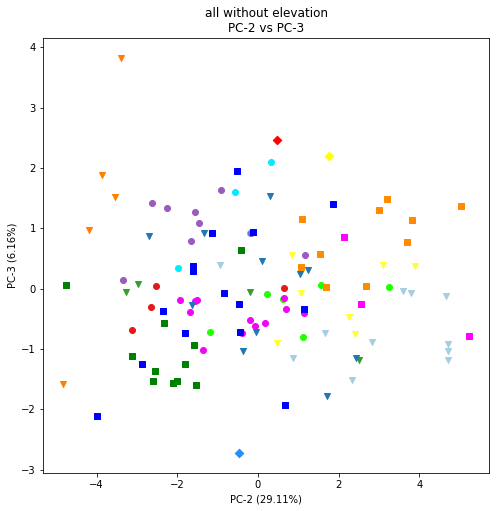

In [12]:
plot_pcas(all_data, use_elevation=False)

### without elevation

all


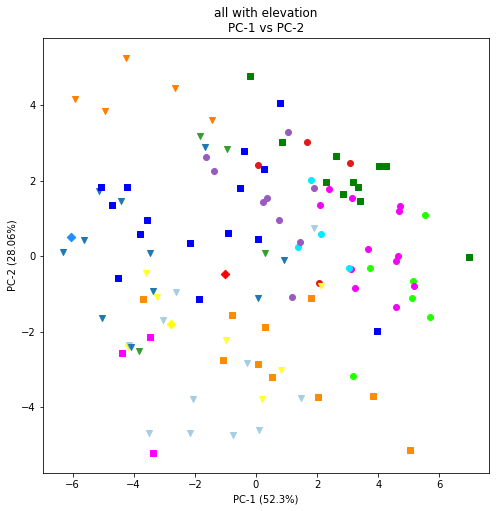

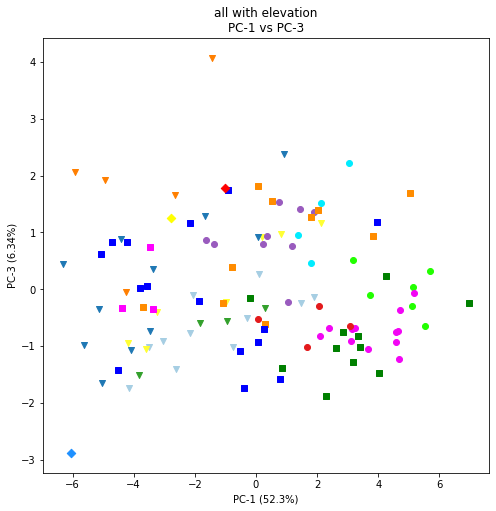

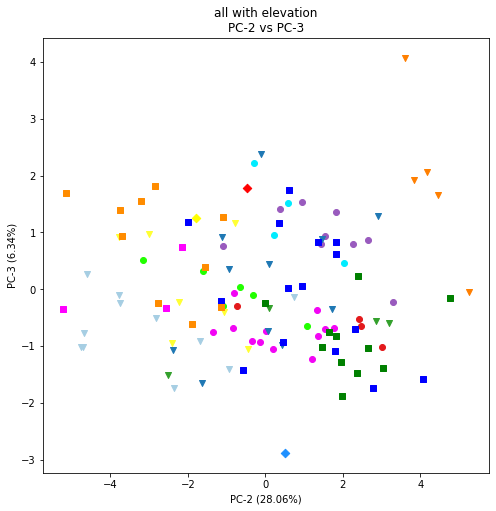

In [13]:
plot_pcas(all_data, use_elevation=True)

In [14]:
formatclock(dt.now() - t1, exact=True)

'0-00:00:12'

[top](#home)